Anastasia Solomatina

Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge 

https://www.leibniz-hki.de/en/applied-systems-biology.html 

HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) 

Adolf-Reichwein-Straße 23, 07745 Jena, Germany

This code is licensed under BSD 2-Clause 

See the LICENSE file provided with this code for the full license.

In [1]:
import os
import python_sbm as ps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import arviz as az
import pyabc
import time
from tqdm import tqdm
from joblib import Parallel, delayed

### Load data & visualize data

In [2]:
path = '../data/whole_expData.dat'
names = ['Time', 'C_N', 'C_M', 'C_E', 'C_A']
df = pd.read_csv(path, sep='\t', header=None, names=names)

# Compute C_K killed population
df['C_K'] = (100 - df['C_A']).clip(lower=0)

cols = ['C_A', 'C_K', 'C_M', 'C_N', 'C_E']
df[cols] = df[cols]/100

mean_df = df.groupby('Time', as_index=False)[cols].mean()
std_df = df.groupby('Time', as_index=False)[cols].std()
std_df = std_df.rename(columns={c: f"sd_{c}" for c in cols})
data_exp = pd.merge(mean_df, std_df, on='Time')

# Extracellular population for predecorated experiment at time = 60 mins
fold_increase = 1.57
CE_EVCa = df.loc[df['Time'] == 60,'C_E'].values*fold_increase

print(data_exp.head())

   Time     C_A     C_K     C_M     C_N     C_E    sd_C_A    sd_C_K    sd_C_M  \
0     0  1.0000  0.0000  0.0000  0.0000  1.0000  0.000000  0.000000  0.000000   
1    10  0.7534  0.2466  0.0198  0.5166  0.4636  0.067671  0.067671  0.006834   
2    20  0.5012  0.4988  0.0290  0.7232  0.2478  0.075965  0.075965  0.008337   
3    40  0.3734  0.6266  0.0478  0.8360  0.1162  0.096914  0.096914  0.012988   
4    60  0.3766  0.6234  0.0512  0.8548  0.0940  0.067719  0.067719  0.007155   

     sd_C_N    sd_C_E  
0  0.000000  0.000000  
1  0.103355  0.105175  
2  0.098446  0.099550  
3  0.080632  0.076917  
4  0.056531  0.055502  


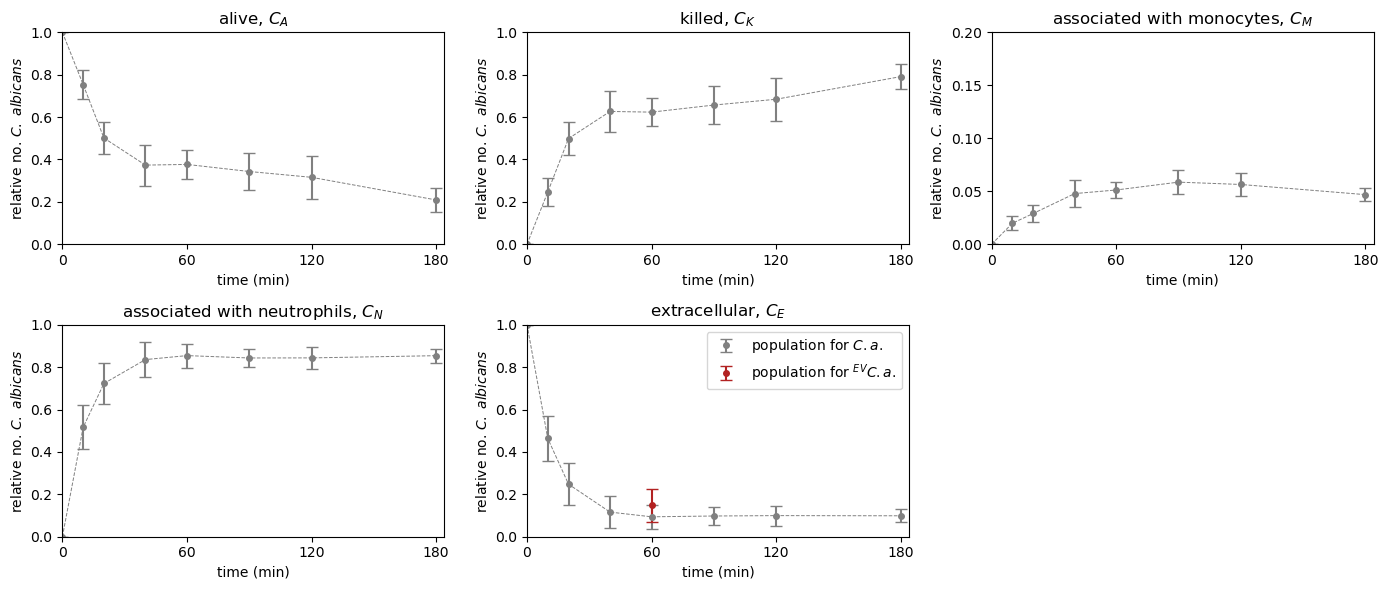

In [3]:
# Visualize data
titles = ['alive, $C_A$', 'killed, $C_K$', "associated with monocytes, $C_M$", 
          'associated with neutrophils, $C_N$','extracellular, $C_E$']

# Set up 2x3 grid (but we’ll use only 5 subplots)
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

lw = 1.5  # example line width

for i, name in enumerate(cols):
    ax = axes[i]
    
    # Plot experimental data
    ax.plot(data_exp["Time"], data_exp[name], color='gray', linewidth=0.7,linestyle="--")
    ax.errorbar(data_exp["Time"], data_exp[name], 
                yerr=data_exp[f"sd_{name}"], fmt='o', capsize=4, 
                markersize=4, color='gray',label="population for $C.a.$")
    
    ax.set_xlim(0, 184)
    ax.set_title(titles[i])

    if name == 'C_M': 
        ax.set_ylim(0, 0.20)
    else:
        ax.set_ylim(0, 1)

    if name == 'C_E':
        ax.errorbar(60, CE_EVCa.mean(), yerr=CE_EVCa.std(), fmt='o', capsize=4, 
                markersize=4, color='firebrick', label='population for $^{EV}C.a.$')
        ax.legend()

    ax.set_xlabel('time (min)')
    ax.set_ylabel(r'relative no. $C.\ albicans$')
    ax.set_xticks([0, 60, 120, 180])

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Compute weights as inverse of mean standard deviation in data

In [4]:
std_data = df.groupby('Time')[cols].std()
mean_std = std_data.iloc[1:].mean()
weights_std = (1 / mean_std).round().astype(int)
w_CE_EVCa = int(round(1 / CE_EVCa.std()))

weights_std['C_E_EVCa'] = w_CE_EVCa

print('Weight vector (1 / mean standard deviation) for', cols + ['C_E_EVCa'])
print(weights_std.values)

Weight vector (1 / mean standard deviation) for ['C_A', 'C_K', 'C_M', 'C_N', 'C_E', 'C_E_EVCa']
[ 13  13 111  15  15  13]


In [5]:
# Create a vector with experimental weighted values
data_wgt = mean_df[['C_A','C_K','C_M','C_N','C_E']].values * weights_std[:5].values
CE_EVCa_wgt = CE_EVCa.mean()*weights_std.iloc[5]
obs = np.concatenate([data_wgt[:,0], data_wgt[:,1], data_wgt[:,2],data_wgt[:,3],data_wgt[:,4],np.ones(10)*CE_EVCa_wgt.mean()])

### Example of the simulated data

In [6]:
output_sim = ps.run_sbm(1,0.5,481,{},{},True)
output_sim.shape

(1, 481, 21)

In [7]:
df_sim = (pd.DataFrame(output_sim.reshape(481,21))
          .rename(columns={0:"C_A",1:"C_K",2:"C_E",3:"C_M",4:"C_G",
                            5:"C_KM",6:"C_KG",7:"C_KE",8:"C_AE",9:"C_RK",10:"C_RA",
                            11:"C_MMK",12:"C_GGK",13:"C_MEK",14:"C_GEK",15:"C_AG",
                            16:"C_AM",17:"C_R",18:"N_PE",19:"k_EK",20:"Time"}))
df_sim

,C_A,C_K,C_E,C_M,C_G,C_KM,C_KG,C_KE,C_AE,C_RK,...,C_MMK,C_GGK,C_MEK,C_GEK,C_AG,C_AM,C_R,N_PE,k_EK,Time
0,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.0
1,0.99981,0.00019,0.98693,0.00055,0.01252,0.00007,0.00012,0.00000,0.98458,0.00000,...,0.00007,0.00012,0.00000,0.00000,0.01240,0.00048,0.00235,0.002500,0.000442,1.0
2,0.99908,0.00092,0.97452,0.00095,0.02453,0.00023,0.00051,0.00018,0.96959,0.00000,...,0.00023,0.00051,0.00000,0.00000,0.02402,0.00072,0.00475,0.002392,0.000863,2.0
3,0.99770,0.00230,0.96201,0.00147,0.03652,0.00044,0.00130,0.00056,0.95476,0.00000,...,0.00044,0.00129,0.00000,0.00001,0.03522,0.00103,0.00669,0.002378,0.001280,3.0
4,0.99581,0.00419,0.94952,0.00199,0.04849,0.00076,0.00222,0.00121,0.93951,0.00000,...,0.00076,0.00221,0.00000,0.00001,0.04627,0.00123,0.00880,0.002382,0.001695,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,0.10973,0.89027,0.14196,0.03538,0.82266,0.03538,0.82256,0.00026,0.00004,0.03207,...,0.02746,0.63388,0.00792,0.18868,0.00010,0.00000,0.14166,0.000000,0.004036,476.0
477,0.10973,0.89027,0.14195,0.03538,0.82267,0.03538,0.82257,0.00025,0.00004,0.03207,...,0.02746,0.63388,0.00792,0.18869,0.00010,0.00000,0.14166,0.000002,0.004017,477.0
478,0.10973,0.89027,0.14194,0.03538,0.82268,0.03538,0.82258,0.00024,0.00004,0.03207,...,0.02746,0.63388,0.00792,0.18870,0.00010,0.00000,0.14166,0.000002,0.003999,478.0
479,0.10973,0.89027,0.14193,0.03538,0.82269,0.03538,0.82259,0.00023,0.00004,0.03207,...,0.02746,0.63388,0.00792,0.18871,0.00010,0.00000,0.14166,0.000002,0.003980,479.0


In [8]:
def model(parameter):
    shift = 3
    rates = dict()
    rates["PhiG"]=10**(parameter["PhiN"]-shift)
    rates["PhiGStar"]=10**(parameter["PhiN"]-shift)
    rates["PhiM"]=10**(parameter["PhiM"]-shift)
    rates["KappaG"]=10**(parameter["KappaN"]-shift)
    rates["KappaM"]=10**(parameter["KappaM"]-shift)
    rates["Rho"]=10**(parameter["Rho"]-shift)
    rates["Gamma"]=10**(parameter["Gamma"]-shift)
    rates["KappaExt"]=10**(parameter["KappaExt"]-shift)
        
    weights = [13,13,111,15,15,13]
    
    cells = dict()
    size = 1e+03
    cells['ALIVEEXTERNCANDIDA'] = size
    cells['MONOCYTES'] = 0.5*size
    cells['GRANULOCYTES'] = 5*size
    cells["DECORATED"] = 0
    
    output = ps.run_sbm(1,0.5,481,cells,rates,False)
    sel1 = output[0, [0,2*10,2*20,2*40,2*60,2*90,2*120,2*180], :][:, [0,1,3,4,2]] # C_A, C_K, C_M, C_N, C_E
    sel1 = sel1*weights[:5]
    out_sim1 = np.concatenate([sel1[:,0], sel1[:,1], sel1[:,2], sel1[:,3], sel1[:,4]])

    rates["PhiG"] = 10**(parameter["PhiND"]-shift)
    
    output2 = ps.run_sbm(1,0.5,481,cells,rates,False)
    sel2 = output2[0,2*60,:][[2]][0]
    out_sim2 = sel2*weights[5]*np.ones(10)
    
    out_sim = np.concatenate([out_sim1,out_sim2])
    
    return {"data": out_sim}

In [9]:
prior = pyabc.Distribution(PhiN=pyabc.RV("uniform", 0, 4),
                           PhiND=pyabc.RV("uniform", 0, 4),
                           PhiM=pyabc.RV("uniform", 0, 4),
                           KappaM=pyabc.RV("uniform", 0, 4),
                           KappaN=pyabc.RV("uniform", 0, 4),
                           Rho=pyabc.RV("uniform", 0, 4),
                           Gamma=pyabc.RV("uniform", 0, 4),
                           KappaExt=pyabc.RV("uniform", 0, 4))

def distance(x, x0):
    return np.mean((x['data'] - x0['data'])**2)

In [10]:
abc = pyabc.ABCSMC(
    models=model,
    parameter_priors=prior,
    distance_function=distance,
    population_size=2000,
)

folder = 'abc_data'
os.makedirs(folder, exist_ok=True)

db_path = os.path.join(os.getcwd()+'/abc_data/temp.db')
observation = obs

ABC.Sampler INFO: Parallelize sampling on 12 processes.


In [11]:
df_list = list()
for chain in tqdm(range(2)):
    abc.new("sqlite:///" + db_path, {"data": observation})
    history = abc.run(minimum_epsilon=0.25, max_nr_populations=50)#0.001
    w,df=history.get_distribution(m=0)
    df = w.reset_index().rename_axis("draw")[["Gamma","KappaExt","KappaN","KappaM","PhiN","PhiM","Rho","PhiND"]].assign(chain=chain).reset_index().set_index(["chain","draw"])
    df_list.append(df)

  0%|                                                                                | 0/2 [00:00<?, ?it/s]ABC.History INFO: Start <ABCSMC id=5, start_time=2025-11-19 12:24:33>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.87944428e+01.
ABC INFO: Accepted: 2000 / 3914 = 5.1099e-01, ESS: 2.0000e+03.
ABC INFO: t: 1, eps: 1.76815815e+01.
ABC INFO: Accepted: 2000 / 4045 = 4.9444e-01, ESS: 7.7240e+02.
ABC INFO: t: 2, eps: 1.16602946e+01.
ABC INFO: Accepted: 2000 / 4371 = 4.5756e-01, ESS: 1.0220e+03.
ABC INFO: t: 3, eps: 8.14450468e+00.
ABC INFO: Accepted: 2000 / 5401 = 3.7030e-01, ESS: 8.5589e+02.
ABC INFO: t: 4, eps: 6.37903700e+00.
ABC INFO: Accepted: 2000 / 6398 = 3.1260e-01, ESS: 1.0737e+03.
ABC INFO: t: 5, eps: 5.16109198e+00.
ABC INFO: Accepted: 2000 / 7673 = 2.6065e-01, ESS: 8.8205e+02.
ABC INFO: t: 6, eps: 4.29735299e+00.
ABC INFO: Accepted: 2000 / 8386 = 2.3849e-01, ESS: 1.0647e+03.
ABC INFO: t: 7, eps: 3.55278837e+00.
ABC INFO: Accepted: 2000 / 8174 = 2.4468e-01, ESS

In [12]:
def func_model(df):
    ddd = model({key:val for key,val in list(zip(["Gamma","KappaExt","KappaN","KappaM","PhiN","PhiM","Rho","PhiND"],df.values))})
    return ddd["data"]
list_xr = list()
num_samples = 500
for j in range(2):
    dat = df_list[j].sample(num_samples)
    list_samples = list()
    list_samples= Parallel(n_jobs=-1)(delayed(func_model)(dat.iloc[i] ) for i in tqdm(range(num_samples)))
    list_xr.append(np.stack(list_samples))

100%|████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.68it/s]


In [13]:
fulldf=np.stack(list_xr)
xr_data = xr.DataArray(fulldf, 
        coords={'simulator_dim_3': np.arange(50),"chain":np.arange(2),"draw":np.arange(num_samples)}, 
        dims=['chain','draw','simulator_dim_3'])
xr_data.name = 'simulator'

In [14]:
name = 'PYABC_sbm'
dataset = az.convert_to_inference_data(xr.Dataset.from_dataframe(pd.concat(df_list)))
dataset.extend(az.convert_to_inference_data(xr_data,group='posterior_predictive'))
dataset.to_netcdf('abc_data/'+name+'.nc')

'abc_data/PYABC_sbm.nc'

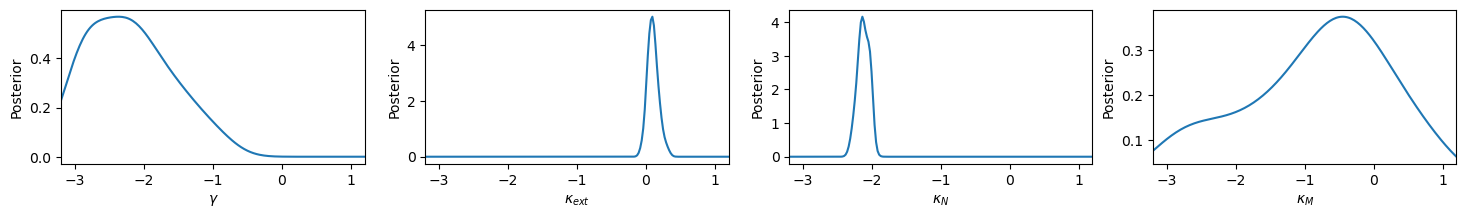

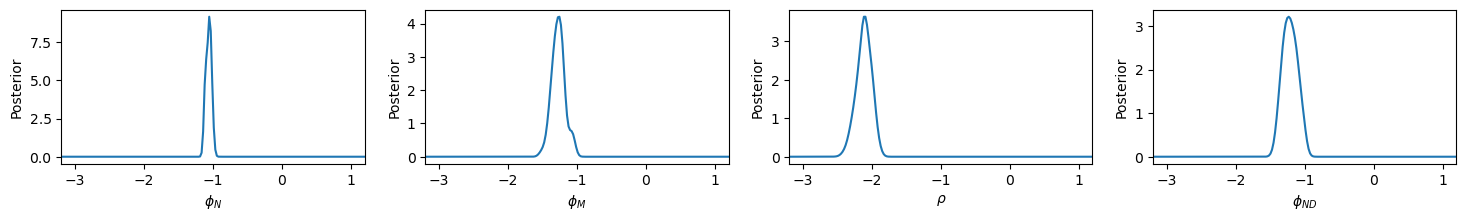

In [15]:
params_name = list(dataset.posterior.data_vars.keys())
params_lbls = ['$\gamma$','$\kappa_{ext}$','$\kappa_N$','$\kappa_M$','$\phi_N$','$\phi_M$',r'$\rho$','$\phi_{ND}$']

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(18,2))
i = 0
for ax in axes:
    if i<len(params_name):
        par_nam = params_name[i]
        par_lbl = params_lbls[i]
        
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df-3, w, xmin=-3.2, xmax=1.2, x=par_nam, xname=par_lbl, ax=ax, numx=200)#, label=f"PDF t={t}")    
    i += 1

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(18,2))
for ax in axes:
    if i<len(params_name):
        par_nam = params_name[i]
        par_lbl = params_lbls[i]
        
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df-3, w, xmin=-3.2, xmax=1.2, x=par_nam, xname=par_lbl, ax=ax, numx=200)#, label=f"PDF t={t+1}")
    
    i += 1    